<a href="https://colab.research.google.com/github/aRod209/pytorch-for-deep-learning/blob/main/lectures/04_pytorch_custom_datasets_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. PyTorch Custom Dataasets Video Notebook

We've used some datasets with PyTorch before.

But how do we get your own data in PyTorch?

One of the ways to do so is via: custom datasets.

## Domain libraries

Depending on what you're working on, vision, text, audio, recommendation, you'll want to look into each of the PyTorch domain libraries for existing data loading functions and customizable data loading functions.

**Resources:**
* Book version of the course materials for 04: https://www.learnpytorch.io/04_pytorch_custom_datasets/
* Ground truth version of notebook 04:

https://github.com/mrdbourke/pytorch-deep-learning/blob/main/04_pytorch_custom_datasets.ipynb

## 0. Importing PyTorch and setting up device-agnostic code

In [1]:
import torch
from torch import nn

# Note: PyTorch 1.10.0 + is required for this course
torch.__version__

'2.2.1+cu121'

In [2]:
# Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [3]:
if device == 'cuda':
  !nvidia-smi

## 1. Get Data

Our dataset is a subset of the [Food101](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/) dataset.

Food101 starts 101 different classes of food and 1000 images per class (750 training, 250 testing).

Our dataset starts with 3 classes of food and only 10% of the images (~75 training, 25 testing).

Why do this?

When starting out ML projects, it's important to try things on a small scale and then increase the scale when necessary.

The whole point is to speed up how fast you can experiment.

In [4]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path('data/')
image_path = data_path / 'pizza_steak_sushi'

data_path, image_path

(PosixPath('data'), PosixPath('data/pizza_steak_sushi'))

In [5]:
# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
  print(f'{image_path} directory already exists... skipping download')
else:
  print(f'{image_path} does not exist, creating one...')
  image_path.mkdir(parents=True, exist_ok=True)

data/pizza_steak_sushi does not exist, creating one...


In [6]:
# Download pizza, steak and sushi data
with open(data_path / 'pizza_steak_sushi.zip', 'wb') as f:
  response = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip')
  print(f'Downloading pizza, steak, and sushi data...')
  f.write(response.content)

In [7]:
# Unzip pizza, steak, and sushi data
with zipfile.ZipFile(data_path / 'pizza_steak_sushi.zip', 'r') as zip_ref:
  print('Unzipping pizza, steak, and sushi data...')
  zip_ref.extractall(image_path)

Unzipping pizza, steak, and sushi data...


## 2. Becoming one with the data (data preparation and data exploration)

In [8]:
import os
def walk_through_dir(dir_root):
  """Walks through dir_path returning its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_root):
    print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}')

In [9]:
walk_through_dir(image_path)

There are 2 directories and 0 images in data/pizza_steak_sushi
There are 3 directories and 0 images in data/pizza_steak_sushi/train
There are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi
There are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza
There are 0 directories and 75 images in data/pizza_steak_sushi/train/steak
There are 3 directories and 0 images in data/pizza_steak_sushi/test
There are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi
There are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza
There are 0 directories and 19 images in data/pizza_steak_sushi/test/steak


In [10]:
# Setup train and testing paths
train_dir = image_path / 'train'
test_dir = image_path / 'test'

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing an image

Let's write some code to:
1. Get all of the image paths
2. Pick a random image path using Python's random.choice()
3. Get the image class name using `pathlib.Path.parent.stem`
4. Since we're working with images let's open the image with Python's PIL
5. We'll then show the image and  print metadata

In [11]:
image_path

PosixPath('data/pizza_steak_sushi')

Random image path: data/pizza_steak_sushi/train/sushi/121940.jpg
Image class: sushi
Image height: 382
Image width: 512


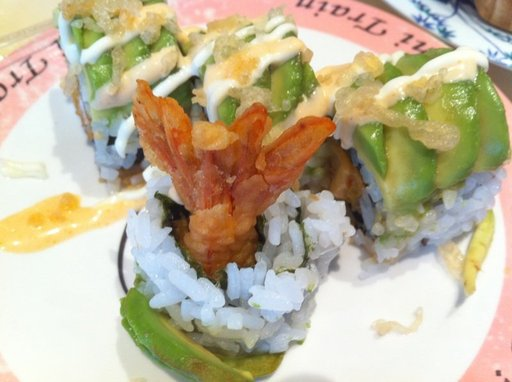

In [12]:
import random
from PIL import Image

# Set seed
random.seed(42)

# 1. Get all of the image paths
image_path_list = list(image_path.glob('*/*/*.jpg'))

# 2. Pick a random image path using Python's random.choice()
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f'Random image path: {random_image_path}')
print(f'Image class: {image_class}')
print(f'Image height: {img.height}')
print(f'Image width: {img.width}')
img

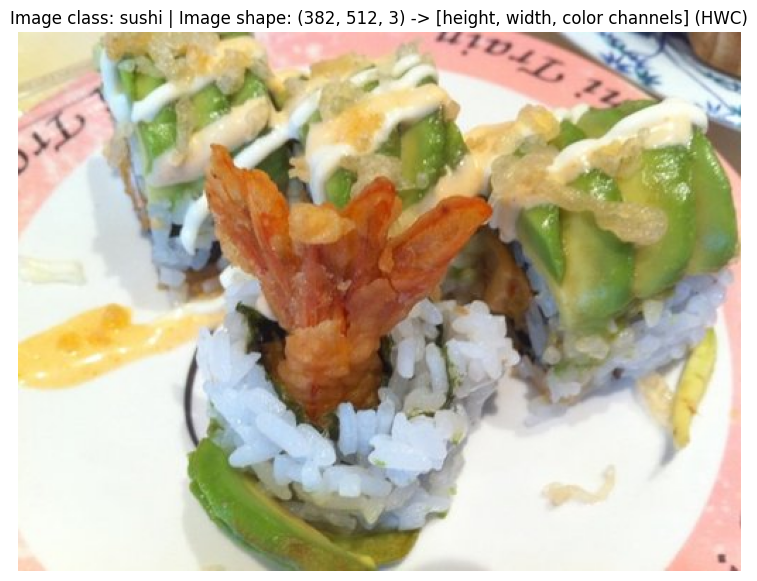

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f'Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color channels] (HWC)')
plt.axis(False);

array([[[236, 232, 185],
        [237, 233, 186],
        [238, 234, 187],
        ...,
        [131,  90,  62],
        [127,  86,  58],
        [128,  87,  59]],

       [[236, 232, 185],
        [237, 233, 186],
        [238, 234, 187],
        ...,
        [131,  90,  62],
        [127,  86,  58],
        [126,  85,  57]],

       [[236, 232, 185],
        [236, 232, 185],
        [237, 233, 186],
        ...,
        [133,  92,  62],
        [130,  89,  59],
        [126,  85,  55]],

       ...,

       [[253, 209, 184],
        [253, 211, 186],
        [255, 212, 185],
        ...,
        [249, 194, 187],
        [255, 202, 195],
        [251, 196, 189]],

       [[251, 209, 184],
        [252, 212, 186],
        [254, 212, 187],
        ...,
        [212, 159, 153],
        [245, 192, 186],
        [254, 201, 195]],

       [[253, 213, 187],
        [254, 214, 188],
        [255, 215, 189],
        ...,
        [184, 131, 127],
        [231, 178, 172],
        [248, 195, 189]]], dtype=uint8)
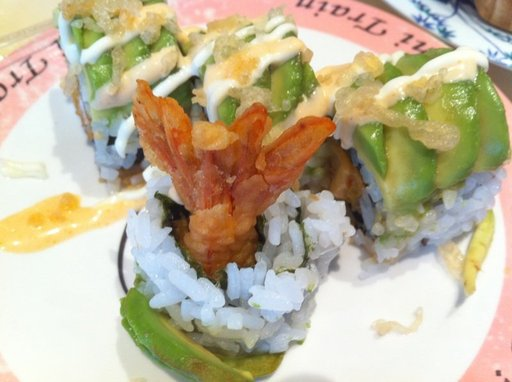

In [14]:
img_as_array

## 3. Transforming data

Before we can use our image data with PyTorch:
1. Turn your target data into tensors (in our caase, numerical representation of our images).
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we'll call these `Dataset` and `DataLoader`.

In [15]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import v2 # Lecture uses version 1, I will use version 2.

### 3.1 Transforming data with `torchvision.transform`

Transforms help you get your images ready to be used with a model/perform data augmentation - https://pytorch.org/vision/stable/transforms.html

In [16]:
# Write a transform for image.
data_transform = v2.Compose([
    # Turn the image into a torch.Tensor
    v2.ToImage(),
    # Resize our images to 64x64
    v2.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    v2.RandomHorizontalFlip(p=0.5),
])

In [17]:
data_transform(img).dtype, data_transform(img).shape, data_transform(img)

(torch.uint8,
 torch.Size([3, 64, 64]),
 Image([[[238, 238, 238,  ..., 145, 158, 143],
         [240, 239, 238,  ..., 139, 155, 143],
         [241, 239, 239,  ..., 137, 148, 139],
         ...,
         [251, 252, 252,  ..., 251, 246, 252],
         [252, 251, 253,  ..., 241, 209, 250],
         [253, 252, 252,  ..., 251, 238, 225]],
 
        [[233, 232, 229,  ..., 112, 129, 106],
         [232, 230, 229,  ..., 107, 128, 108],
         [232, 229, 228,  ..., 105, 120, 104],
         ...,
         [241, 250, 253,  ..., 201, 200, 201],
         [226, 234, 251,  ..., 184, 160, 201],
         [213, 217, 242,  ..., 189, 179, 171]],
 
        [[188, 192, 190,  ...,  85, 104,  76],
         [184, 184, 183,  ...,  78, 100,  77],
         [179, 177, 179,  ...,  75,  91,  76],
         ...,
         [224, 239, 244,  ..., 191, 192, 195],
         [206, 216, 240,  ..., 173, 153, 191],
         [188, 194, 228,  ..., 177, 172, 164]]], dtype=torch.uint8, ))

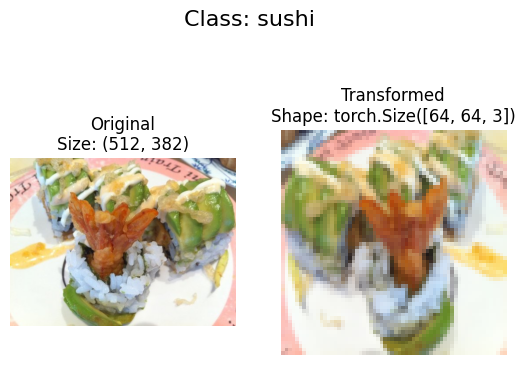

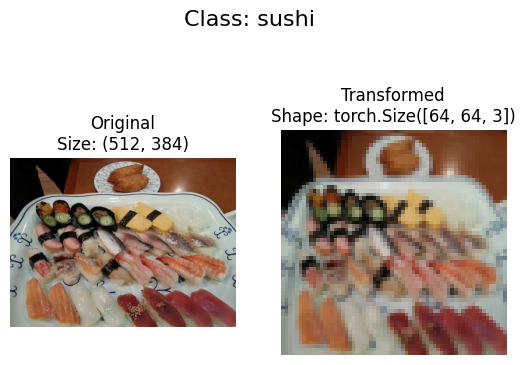

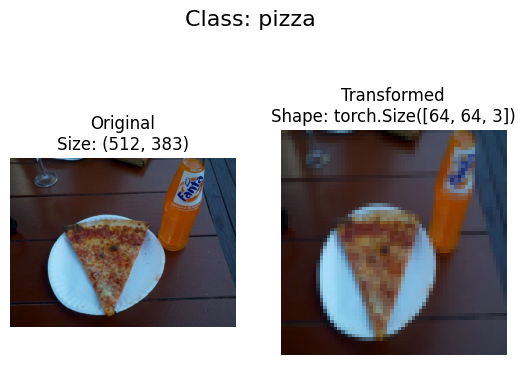

In [18]:
def plot_transformed_images(image_paths, transform, n=3, seed=None):
  """
  Selects random images from a path of images and loads/transforms them
  then plots the original vs the transformed version.
  """

  if seed:
    random.seed(seed)

  random_image_paths = random.sample(image_paths, k=n)

  for image_path in random_image_paths:
    with Image.open(image_path) as image:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(image)
      ax[0].set_title(f'Original\nSize: {image.size}')
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(image).permute(1, 2, 0) # note we will need to change shape for matplotlib (C, H, W) -> (H, W, C)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f'Transformed\nShape: {transformed_image.shape}')
      ax[1].axis('off')

      fig.suptitle(f'Class: {image_path.parent.stem}', fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        seed=42)

## 4. Option 1: Loading image data using `ImageFolder`

We can load image classification data using `torchvision.datasets.ImageFolder` https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder

In [19]:
# Use Image Folder to create datasets
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # a transform for the data
                                  target_transform=None) # transform for the label/target

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                  ToImage()
                  Resize(size=[64, 64], interpolation=InterpolationMode.BILINEAR, antialias=True)
                  RandomHorizontalFlip(p=0.5)
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                  ToImage()
                  Resize(size=[64, 64], interpolation=InterpolationMode.BILINEAR, antialias=True)
                  RandomHorizontalFlip(p=0.5)
            ))

In [20]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [21]:
# Get class names as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [22]:
# Get class names as a dictionary
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [23]:
# Check the lengths of our dataset
len(train_data), len(test_data)

(225, 75)

In [24]:
# Check a target and the corresponding sample of the target
train_data.targets[0], train_data.samples[0]

(0, ('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0))

In [25]:
# Index on the train_data Dataset to get a single image and label
img, label = train_data[0]
print(f'Image tensor:\n {img}')
print(f'\nImage shape: {img.shape}')
print(f'Image label: {label}')
print(f'Label datatype: {type(label)}')

Image tensor:
 Image([[[30, 31, 32,  ..., 25, 26, 29],
        [33, 33, 33,  ..., 25, 25, 27],
        [34, 34, 34,  ..., 24, 25, 26],
        ...,
        [43, 42, 43,  ..., 32, 28, 28],
        [43, 42, 43,  ..., 28, 24, 23],
        [42, 42, 43,  ..., 25, 22, 22]],

       [[15, 15, 15,  ..., 19, 18, 19],
        [16, 16, 16,  ..., 19, 18, 19],
        [18, 18, 18,  ..., 19, 19, 18],
        ...,
        [61, 61, 64,  ..., 35, 34, 32],
        [59, 61, 64,  ..., 32, 30, 28],
        [58, 60, 62,  ..., 29, 27, 26]],

       [[ 5,  5,  4,  ..., 23, 23, 24],
        [ 5,  4,  5,  ..., 23, 22, 23],
        [ 5,  4,  4,  ..., 23, 23, 23],
        ...,
        [47, 48, 50,  ..., 38, 34, 33],
        [46, 47, 49,  ..., 32, 29, 28],
        [45, 46, 48,  ..., 27, 25, 27]]], dtype=torch.uint8, )

Image shape: torch.Size([3, 64, 64])
Image label: 0
Label datatype: <class 'int'>


In [26]:
class_names[label]

'pizza'

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute: torch.Size([64, 64, 3]) -> [height, width, color_channels]


Text(0.5, 1.0, 'pizza')

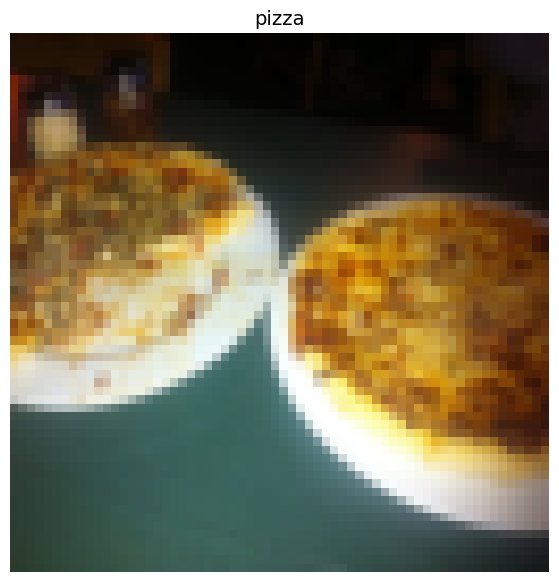

In [27]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes
print(f'Original shape: {img.shape} -> [color_channels, height, width]')
print(f'Image permute: {img_permute.shape} -> [height, width, color_channels]')

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis('off')
plt.title(class_names[label], fontsize=14)

### 4.1 Turn loaded images into `DataLoader''s

A `DataLoader` is going to help us turn our `Datset`'s into iterables and we can customize the `batch_size` so our model can see our `batch_size` images at a time.

In [28]:
import os
os.cpu_count()

2

In [29]:
# Turn train and test datasets into DataLoader's
from torch.utils.data import DataLoader

BATCH_SIZE = 1

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=os.cpu_count(),
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7d7d0c9a1630>,
 <torch.utils.data.dataloader.DataLoader at 0x7d7d0cb45b40>)

In [30]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [31]:
len(train_data), len(test_data)

(225, 75)

In [32]:
img, label = next(iter(train_dataloader))

# Batch size qill now be 1, you can change the batch size if you like
print(f'Image shape: {img.shape} -> [batch_size, color_channels, height, width]')
print(f'Label shape: {label.shape}')

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


## 5. Option 2: Loading Image Data with a Custom `Dataset`

1. Want to be able to load images from file
2. Want to be able to get class names from the Dataset
3. Want to be able to get classes as dictionary from the Dataset

Pros:
* Can create a `Dataset` out of almost anything
* Not limited to PyTorch pre-built `Dataset` functions

Cons:
* Even though you could create `Dataset` out of almost anything, it doesn't mean it will work...
* Using a custom `Dataset` often results in us writing more code, which could be prone to errors or performance issues

All custom datasets in PyTorch, often subclass - https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset

In [33]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [34]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

We want a function to:
1. Get the class names using `os.scandir()` to traverse a target directory (ideally the directory is in standard image classification format).
2. Raise an error if the class names aren't found (if this happens, there might be something wrong with the directory structure).
3. Turn the class names into a dict and a list and return them.

In [35]:
# Setup path for target directory
target_directory = train_dir
print(f'Target dir: {target_directory}')

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [36]:
list(os.scandir(target_directory))

[<DirEntry 'sushi'>, <DirEntry 'pizza'>, <DirEntry 'steak'>]

In [37]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  """Finds the class folder names in a target directory."""
  # 1. Get the class names by scanning the target directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # Rais an error if class names could not be found
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}... please check file structure.")

  # 3. Create a dictionary of index labels (computers prefer numbers rather than strings as labels)
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}

  return classes, class_to_idx

In [38]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

To create our own custom dataset, we want to:

1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directory (the directory we'd like to get data from) as well as a transform if we'd like to transform our data.
3. Create several attributes:
  * paths - paths of our images
  * transform - the transform we'd like to use
  * classes - a list of the target classes
  * class_to_idx - a dict of the target classes mapped to integer labels
4. Create a function to `load_images()`, this function will open an image
5. Overwrite the `__len()__` method to return the length of our dataset.
6. Overwrite the `__getitem()__` method to return a given sample when passed an index

In [42]:
# Write a custom dataset class
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
  # 2. Initialize our custom dataset
  def __init__(self, targ_dir: str, transform=None):
    # 3. Create class attributes
    # Get all of the image paths
    self.paths = list(pathlib.Path(targ_dir).glob('*/*.jpg'))
    # Setup transform
    self.transform = transform
    # Create classes and class_to_idx attributes
    self.classes, self.class_to_idx = find_classes(targ_dir)

  # 4. Create a function to load images
  def load_image(self, index: int) -> Image.Image:
    "Opens a image via a path and returns it."
    image_path = self.paths[index]
    return Image.open(image_path)

  # 5. Overwrite __len__()
  def __len__(self) -> int:
    "Returns the total number of samples."
    return len(self.paths)

  # 6. Overwrite __getitem__() method to return a particular sample
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    "Returns one sample of data, data and label (X, y)."
    img = self.load_image(index)
    class_name = self.paths[index].parent.name # expects path in format: data_folder/class_name/image.jpg
    class_idx = self.class_to_idx[class_name]

    # Transform if neccessary
    if self.transform:
      return self.transform(img), class_idx # return data, label (X, y)
    else:
      return img, class_idx # return untransformed image and label

In [43]:
# Create a transform
from torchvision.transforms import transforms
train_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [44]:
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms)

In [45]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7d7d0ca56e90>,
 <__main__.ImageFolderCustom at 0x7d7d0ca57730>)

In [46]:
train_data

Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
                 ToImage()
                 Resize(size=[64, 64], interpolation=InterpolationMode.BILINEAR, antialias=True)
                 RandomHorizontalFlip(p=0.5)
           )

In [47]:
len(train_data), len(train_data_custom)

(225, 225)

In [48]:
len(test_data), len(test_data_custom)

(75, 75)

In [49]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [51]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [52]:
# Check for equality between original ImageFolder dataset and ImageFolderCustomDataset
print(train_data_custom.classes==train_data.classes)
print(test_data_custom.classes==test_data.classes)

True
True
